## 📓 Notebook Manager

This cell initializes the widgets required for managing your research notebook. Please run the cell below to enable functionality for:
- Exporting cells tagged with `export` into a `clean` notebook
- Generating a dynamic Table of Contents (TOC)
- Exporting the notebook to GitHub-compatible Markdown

➡️ **Be sure to execute the next cell before continuing with any editing or exporting.**

In [13]:
# Cell 1 - Workflow Tools
import sys
sys.path.insert(0, '../../lib')
sys.path.insert(0, '../../scripts') 

from notebook_tools import TOCWidget, ExportWidget
import ipywidgets as widgets


# Create widget instances
toc = TOCWidget()
export = ExportWidget()

# Create horizontal layout
left_side = widgets.VBox([toc.button, export.button, toc.status])
right_side = widgets.VBox([toc.output, export.output])

# Display side by side
display(widgets.HBox([left_side, right_side]))

# 🚗 Experiment Preprocessing - Car Counting v2.01

## 🎯 Purpose
This notebook implements a simplified preprocessing workflow for car counting experiments. It extracts frames from GDOT traffic camera videos for manual annotation and YOLO model training.

## 📋 Context
- **Data Source**: GDOT traffic camera recordings
- **Video Specs**: 480p resolution, 15 fps, ~15 minute duration
- **Goal**: Extract frames for vehicle counting model training

## 🔄 Workflow Overview
1. Video selection (closest to noon from target date)
2. Frame extraction (evenly spaced samples)
3. Quality filtering (brightness/blur)
4. Color normalization (BGR→RGB)
5. Data organization for annotation

## 📁 Output Structure
```
data/experiments/[experiment_name]/[date]/[camera]/
├── frames/           # raw extracted frames
├── quality/          # quality-filtered frames  
├── normalized/       # RGB-normalized frames
└── metadata.json     # processing summary
```

## 🎮 Next Steps
1. Run preprocessing → manual annotation in CVAT → YOLO training
2. Start with simplest YOLO model for vehicle counting

**Version**: 2.01 | **Type**: Experiment Preprocessing | **Target**: Car Counting

<!-- TOC -->


## 🔧 Experiment Configuration Parameters

This cell defines all parameters for the experiment preprocessing workflow. Parameters are organized into categories with emoji indicators:

### Target Parameters  
- 🎯 **VIDEO_ID**: Specific camera to process (e.g., ATL-1005)
- 🎯 **BATCH_DATE**: Date from batch analysis (YYYYMMDD format)  
- 🎯 **TARGET_HOUR**: Target hour for video selection (12 = noon)
- 🎯 **EXPERIMENT_NAME**: Unique identifier for this experiment

### Path Configuration
- 📁 **INPUT_BASE**: Root directory for video recordings
- 📁 **OUTPUT_BASE**: Root directory for experiment output

### Processing Settings
- 📊 **FRAMES_TO_EXTRACT**: Total number of frames to extract
- 📊 **SAMPLE_RATE**: Extract every Nth frame from video

### Quality Thresholds
Relaxed values for experiment data collection:
- 🔍 **brightness_min/max**: Acceptable brightness range (0-255)
- 🔍 **blur_min**: Minimum blur score (Laplacian variance)

**Note**: These values are hardcoded for initial experiments. Future versions will support parameter files.


In [1]:
# experiment configuration parameters
from pathlib import Path

CONFIG = {
    # target parameters
    'VIDEO_ID': 'ATL-1005',  # 🎯 camera to process
    'BATCH_DATE': '20250620',  # 🎯 date from batch analysis
    'TARGET_HOUR': 12,  # 🎯 target hour (noon)
    'EXPERIMENT_NAME': 'car_counting_v1',  # 🎯 experiment identifier
    
    # path configuration  
    'INPUT_BASE': Path.home() / 'traffic-recordings',  # 📁 video source
    'OUTPUT_BASE': Path('../../data/experiments'),  # 📁 experiment output
    
    # processing settings
    'FRAMES_TO_EXTRACT': 50,  # 📊 total frames to extract
    'SAMPLE_RATE': 15,  # 📊 extract every Nth frame
    
    # quality measurement (no hardcoded thresholds)
    'MEASURE_QUALITY': True,  # 📊 calculate brightness/blur metrics
    
    # video settings (480p, 15fps)
    'JPEG_QUALITY': 95  # 🎥 output quality (0-100)
}

# derived paths
date_formatted = f"{CONFIG['BATCH_DATE'][:4]}-{CONFIG['BATCH_DATE'][4:6]}-{CONFIG['BATCH_DATE'][6:8]}"
CONFIG['OUTPUT_DIR'] = CONFIG['OUTPUT_BASE'] / CONFIG['EXPERIMENT_NAME'] / date_formatted / CONFIG['VIDEO_ID']
CONFIG['VIDEO_DIR'] = CONFIG['INPUT_BASE'] / CONFIG['VIDEO_ID'] / date_formatted

print("Experiment Configuration:")
print(f"  Experiment: {CONFIG['EXPERIMENT_NAME']}")
print(f"  Processing: {CONFIG['VIDEO_ID']} from {date_formatted}")
print(f"  Output to: {CONFIG['OUTPUT_DIR']}")

Experiment Configuration:
  Experiment: car_counting_v1
  Processing: ATL-1005 from 2025-06-20
  Output to: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005


## 🔧 Environment Setup

This cell establishes the experiment preprocessing environment by:

1. **Import Required Libraries**
   - OpenCV (cv2) for video processing and frame extraction
   - NumPy for array operations and numerical computations
   - Pandas for data organization and metadata management
   - System utilities for path handling and file operations

2. **Library Verification**
   - Check OpenCV installation and version
   - Verify NumPy and Pandas availability
   - Display version information for debugging

3. **Initialize Helper Functions**
   - **calculate_brightness()**: Compute average pixel intensity (0-255)
   - **calculate_blur_score()**: Measure sharpness using Laplacian variance
   - **get_video_metadata()**: Extract video properties (fps, resolution, duration)

4. **Directory Setup**
   - Create experiment output directory structure
   - Ensure path exists before processing begins

**Note**: This cell must run successfully before proceeding with video processing.

In [2]:
# environment setup
import cv2
import numpy as np
import pandas as pd
import os
import sys
import json
import logging
from datetime import datetime, timedelta

# setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# verify opencv
try:
    print(f"✓ OpenCV version: {cv2.__version__}")
except ImportError:
    print("⚠️ OpenCV not installed. Install with: pip install opencv-python")
    
print(f"✓ Python version: {sys.version.split()[0]}")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")

# helper functions
def calculate_brightness(frame):
    """Calculate average brightness of frame"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

def calculate_blur_score(frame):
    """Calculate Laplacian variance (higher = sharper)"""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def get_video_metadata(video_path):
    """Extract video metadata"""
    metadata = {}
    cap = cv2.VideoCapture(str(video_path))
    if cap.isOpened():
        metadata['fps'] = cap.get(cv2.CAP_PROP_FPS)
        metadata['frame_count'] = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        metadata['width'] = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        metadata['height'] = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        metadata['duration_seconds'] = metadata['frame_count'] / metadata['fps'] if metadata['fps'] > 0 else 0
        cap.release()
    return metadata

# create output directory
CONFIG['OUTPUT_DIR'].mkdir(parents=True, exist_ok=True)

print(f"\n✓ Environment setup complete")
print(f"  Output directory created: {CONFIG['OUTPUT_DIR']}")

✓ OpenCV version: 4.11.0
✓ Python version: 3.12.9
✓ NumPy version: 2.2.4
✓ Pandas version: 2.2.3

✓ Environment setup complete
  Output directory created: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005


## 📹 Video Ingestion & Selection

This module finds the target video from the specified camera and date using the same logic as the batch processing workflow.

### Process
- Searches for videos matching the camera ID and batch date
- Parses timestamps from filenames (format: CAMERA_YYYYMMDD_HHMMSS.mp4)
- Calculates time difference from target hour (noon)
- Selects video closest to target time
- Extracts basic metadata (resolution, duration, frame count)

### Expected File Pattern
`ATL-1005_20250620_120347.mp4` (camera_date_time.mp4)

**Note**: If no videos are found, check the INPUT_BASE path and date format.

In [3]:
# video ingestion and selection
def parse_timestamp(filename):
    """extract timestamp from filename"""
    parts = filename.stem.split('_')
    if len(parts) >= 3:
        time_str = parts[2]
        hours = int(time_str[:2])
        minutes = int(time_str[2:4])
        return hours * 60 + minutes  # minutes from midnight
    return None

# find videos
video_files = list(CONFIG['VIDEO_DIR'].glob(f"{CONFIG['VIDEO_ID']}_*.mp4"))

if not video_files:
    raise FileNotFoundError(f"No videos found for {CONFIG['VIDEO_ID']} on {CONFIG['BATCH_DATE']}")

# find closest to target hour
target_minutes = CONFIG['TARGET_HOUR'] * 60  # 720 minutes for noon
closest_video = None
min_diff = float('inf')

for video in video_files:
    minutes = parse_timestamp(video)
    if minutes is not None:
        diff = abs(minutes - target_minutes)
        if diff < min_diff:
            min_diff = diff
            closest_video = video

CONFIG['selected_video'] = closest_video
metadata = get_video_metadata(closest_video)
CONFIG['video_metadata'] = metadata

time_str = closest_video.stem.split('_')[2]
print(f"Selected: {closest_video.name}")
print(f"  Starts at: {time_str[:2]}:{time_str[2:4]}:{time_str[4:6]}")
print(f"  Resolution: {metadata['width']}x{metadata['height']}")
print(f"  Duration: {metadata['duration_seconds']:.1f}s ({metadata['duration_seconds']/60:.1f} min)")
print(f"  Frame rate: {metadata['fps']:.1f} fps")

Selected: ATL-1005_20250620_120641.mp4
  Starts at: 12:06:41
  Resolution: 480x270
  Duration: 901.1s (15.0 min)
  Frame rate: 15.0 fps


## 🎞️ Frame Extraction

This module extracts frames from the selected video at specified intervals for experiment processing.

### Process
- Opens the selected video using OpenCV
- Extracts frames using the SAMPLE_RATE (every Nth frame)
- Continues until FRAMES_TO_EXTRACT is reached or video ends
- Saves frames as JPEG files with specified quality
- Creates frames directory in experiment output folder

### Frame Naming
- Format: `frame_0001.jpg`, `frame_0002.jpg`, etc.
- Sequential numbering for easy sorting and reference

**Note**: For 15-minute videos at 15fps, total frames ≈ 13,500. Sample rate of 15 gives ~900 available frames.

In [4]:
# frame extraction
print(f"Frame Extraction")
print(f"Extracting {CONFIG['FRAMES_TO_EXTRACT']} frames (every {CONFIG['SAMPLE_RATE']} frames)")

video_path = CONFIG['selected_video']
cap = cv2.VideoCapture(str(video_path))

if not cap.isOpened():
    raise ValueError(f"Cannot open video: {video_path}")

# create frames directory
frames_dir = CONFIG['OUTPUT_DIR'] / 'frames'
frames_dir.mkdir(exist_ok=True)

# extract frames
frames_extracted = 0
frame_index = 0

while frames_extracted < CONFIG['FRAMES_TO_EXTRACT'] and cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # extract every Nth frame
    if frame_index % CONFIG['SAMPLE_RATE'] == 0:
        frame_filename = f"frame_{frames_extracted:04d}.jpg"
        frame_path = frames_dir / frame_filename
        
        # save frame
        cv2.imwrite(str(frame_path), frame, [cv2.IMWRITE_JPEG_QUALITY, CONFIG['JPEG_QUALITY']])
        
        frames_extracted += 1
        if frames_extracted % 10 == 0:
            print(f"  Extracted {frames_extracted}/{CONFIG['FRAMES_TO_EXTRACT']} frames")
    
    frame_index += 1

cap.release()

CONFIG['frames_dir'] = frames_dir
CONFIG['frames_extracted'] = frames_extracted

print(f"\n✓ Extracted {frames_extracted} frames to {frames_dir}")

Frame Extraction
Extracting 50 frames (every 15 frames)
  Extracted 10/50 frames
  Extracted 20/50 frames
  Extracted 30/50 frames
  Extracted 40/50 frames
  Extracted 50/50 frames

✓ Extracted 50 frames to ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/frames


## 🔍 Quality Analysis

This module analyzes extracted frames for brightness and blur metrics without applying filtering thresholds.

### Process
- Calculates brightness (average pixel intensity 0-255)
- Calculates blur score (Laplacian variance - higher = sharper)
- Records metrics for each frame
- Saves quality report as CSV for review
- Displays distribution of quality metrics

### Quality Metrics
- **Brightness**: Mean grayscale pixel value
- **Blur Score**: Variance of Laplacian operator (sharpness measure)

**Note**: All frames are kept for experiments. Metrics are for analysis only.

In [5]:
# quality analysis
print("Quality Analysis")
print("=" * 60)

# get all extracted frames
frame_files = sorted(CONFIG['frames_dir'].glob("frame_*.jpg"))
print(f"Analyzing quality of {len(frame_files)} frames")

quality_results = []

for frame_path in frame_files:
    # read frame
    frame = cv2.imread(str(frame_path))
    if frame is None:
        continue
    
    # calculate metrics
    brightness = calculate_brightness(frame)
    blur_score = calculate_blur_score(frame)
    
    result = {
        'frame': frame_path.name,
        'brightness': brightness,
        'blur_score': blur_score
    }
    quality_results.append(result)

# save quality report
quality_df = pd.DataFrame(quality_results)
quality_df.to_csv(CONFIG['OUTPUT_DIR'] / 'quality_report.csv', index=False)

CONFIG['quality_results'] = quality_df

print(f"\nQuality Metrics Summary:")
print(f"  Brightness range: {quality_df['brightness'].min():.1f} - {quality_df['brightness'].max():.1f}")
print(f"  Brightness average: {quality_df['brightness'].mean():.1f}")
print(f"  Blur score range: {quality_df['blur_score'].min():.1f} - {quality_df['blur_score'].max():.1f}")
print(f"  Blur score average: {quality_df['blur_score'].mean():.1f}")

print(f"\n✓ Quality analysis complete")
print(f"  Report saved: quality_report.csv")

Quality Analysis
Analyzing quality of 50 frames

Quality Metrics Summary:
  Brightness range: 100.4 - 103.5
  Brightness average: 102.6
  Blur score range: 3459.5 - 3794.0
  Blur score average: 3584.2

✓ Quality analysis complete
  Report saved: quality_report.csv


## 🎨 Color Normalization

This module converts frames from BGR (Blue-Green-Red) to RGB (Red-Green-Blue) color space for consistency with display systems and ML frameworks.

### Process
- OpenCV reads images in BGR format by default
- Converts BGR to RGB using cv2.cvtColor()
- Saves normalized frames for downstream processing
- Creates normalized directory in experiment output

### Technical Details
- BGR: pixel[0]=Blue, pixel[1]=Green, pixel[2]=Red
- RGB: pixel[0]=Red, pixel[1]=Green, pixel[2]=Blue
- Essential for correct color representation in training data

**Note**: This ensures traffic lights appear red (not blue) in annotated data.

Color Space Normalization
Normalizing 50 frames


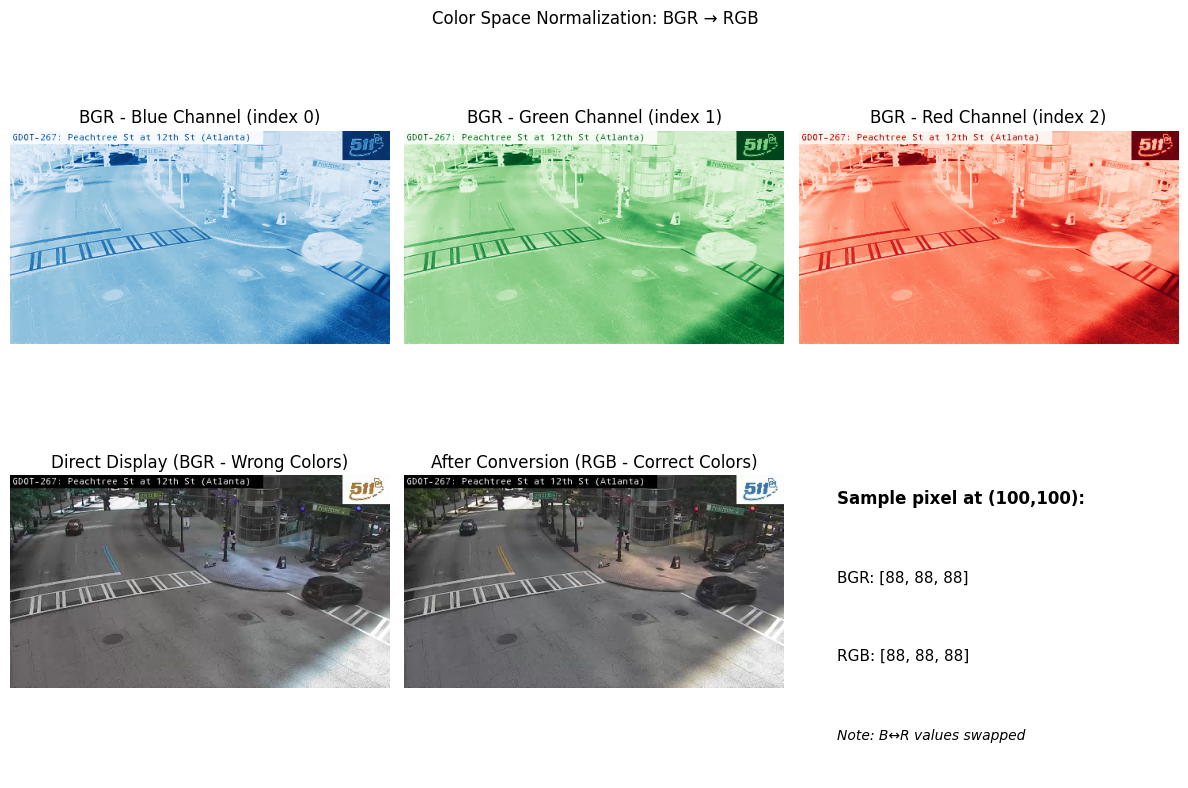


✓ Color normalization complete
  Frames processed: 50
  Output: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/normalized


In [7]:
# color normalization
import matplotlib.pyplot as plt
from PIL import Image

print("Color Space Normalization")
print("=" * 60)

frame_files = sorted(CONFIG['frames_dir'].glob("frame_*.jpg"))
print(f"Normalizing {len(frame_files)} frames")

# create normalized directory
normalized_dir = CONFIG['OUTPUT_DIR'] / 'normalized'
normalized_dir.mkdir(exist_ok=True)

normalized_frames = []

for i, frame_path in enumerate(frame_files):
    # read frame (BGR)
    frame_bgr = cv2.imread(str(frame_path))
    
    # convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    
    # save as true RGB using PIL
    output_path = normalized_dir / frame_path.name
    rgb_image = Image.fromarray(frame_rgb)
    rgb_image.save(str(output_path), 'JPEG', quality=CONFIG['JPEG_QUALITY'])
    normalized_frames.append(output_path)

# show color space difference using first frame
sample = cv2.imread(str(frame_files[0]))
sample_rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# BGR channels
axes[0, 0].imshow(sample[:,:,0], cmap='Blues')
axes[0, 0].set_title('BGR - Blue Channel (index 0)')
axes[0, 0].axis('off')

axes[0, 1].imshow(sample[:,:,1], cmap='Greens')
axes[0, 1].set_title('BGR - Green Channel (index 1)')
axes[0, 1].axis('off')

axes[0, 2].imshow(sample[:,:,2], cmap='Reds')
axes[0, 2].set_title('BGR - Red Channel (index 2)')
axes[0, 2].axis('off')

# RGB display comparison
axes[1, 0].imshow(sample)
axes[1, 0].set_title('Direct Display (BGR - Wrong Colors)')
axes[1, 0].axis('off')

axes[1, 1].imshow(sample_rgb)
axes[1, 1].set_title('After Conversion (RGB - Correct Colors)')
axes[1, 1].axis('off')

# show pixel values
pixel_y, pixel_x = 100, 100
bgr_pixel = sample[pixel_y, pixel_x]
rgb_pixel = sample_rgb[pixel_y, pixel_x]
axes[1, 2].text(0.1, 0.7, f"Sample pixel at ({pixel_x},{pixel_y}):", fontsize=12, weight='bold')
axes[1, 2].text(0.1, 0.5, f"BGR: [{bgr_pixel[0]}, {bgr_pixel[1]}, {bgr_pixel[2]}]", fontsize=11)
axes[1, 2].text(0.1, 0.3, f"RGB: [{rgb_pixel[0]}, {rgb_pixel[1]}, {rgb_pixel[2]}]", fontsize=11)
axes[1, 2].text(0.1, 0.1, "Note: B↔R values swapped", fontsize=10, style='italic')
axes[1, 2].axis('off')

plt.suptitle('Color Space Normalization: BGR → RGB')
plt.tight_layout()
plt.show()

CONFIG['normalized_frames'] = normalized_frames

print(f"\n✓ Color normalization complete")
print(f"  Frames processed: {len(normalized_frames)}")
print(f"  Output: {normalized_dir}")

## 📁 Data Organization

This module creates comprehensive metadata and organizes processed frames for downstream use.

### Process
- Compiles experiment metadata (camera, date, parameters, processing summary)
- Creates frame inventory with quality metrics
- Saves metadata as JSON for experiment tracking
- Saves frame inventory as CSV for easy review
- Links all processing stages and file paths

### Output Files
- `metadata.json`: Complete experiment configuration and results
- `frame_inventory.csv`: Frame-by-frame quality metrics and paths
- Directory structure with clear organization

**Note**: Metadata enables reproducibility and traceability for model training.

In [8]:
# data organization
print("Data Organization")
print("=" * 60)

# compile metadata
metadata = {
    'experiment_name': CONFIG['EXPERIMENT_NAME'],
    'camera_id': CONFIG['VIDEO_ID'],
    'batch_date': CONFIG['BATCH_DATE'],
    'source_video': CONFIG['selected_video'].name,
    'processing_timestamp': datetime.now().isoformat(),
    'parameters': {
        'target_hour': CONFIG['TARGET_HOUR'],
        'frames_to_extract': CONFIG['FRAMES_TO_EXTRACT'],
        'sample_rate': CONFIG['SAMPLE_RATE'],
        'jpeg_quality': CONFIG['JPEG_QUALITY']
    },
    'video_metadata': CONFIG['video_metadata'],
    'processing_summary': {
        'frames_extracted': CONFIG['frames_extracted'],
        'frames_with_quality_data': len(CONFIG['quality_results'])
    }
}

# build frame inventory
frame_inventory = []

for stage, frame_list, stage_name in [
    ('extracted', frame_files, 'Raw extracted frames'),
    ('normalized', normalized_frames, 'RGB normalized frames')
]:
    for frame_path in frame_list:
        # get quality metrics
        quality_row = CONFIG['quality_results'][CONFIG['quality_results']['frame'] == frame_path.name]
        
        entry = {
            'frame_name': frame_path.name,
            'stage': stage,
            'stage_description': stage_name,
            'path': str(frame_path),
            'brightness': quality_row['brightness'].values[0] if not quality_row.empty else None,
            'blur_score': quality_row['blur_score'].values[0] if not quality_row.empty else None
        }
        frame_inventory.append(entry)

# save metadata
metadata_path = CONFIG['OUTPUT_DIR'] / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

# save frame inventory
inventory_df = pd.DataFrame(frame_inventory)
inventory_path = CONFIG['OUTPUT_DIR'] / 'frame_inventory.csv'
inventory_df.to_csv(inventory_path, index=False)

print(f"\nExperiment data structure:")
print(f"  {CONFIG['OUTPUT_DIR']}/")
print(f"  ├── frames/          ({CONFIG['frames_extracted']} raw frames)")
print(f"  ├── normalized/      ({len(normalized_frames)} RGB frames)")
print(f"  ├── metadata.json")
print(f"  ├── frame_inventory.csv")
print(f"  └── quality_report.csv")

CONFIG['metadata'] = metadata
CONFIG['inventory'] = inventory_df

print(f"\n✓ Data organization complete")
print(f"  Metadata: {metadata_path}")
print(f"  Inventory: {inventory_path}")

Data Organization

Experiment data structure:
  ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/
  ├── frames/          (50 raw frames)
  ├── normalized/      (50 RGB frames)
  ├── metadata.json
  ├── frame_inventory.csv
  └── quality_report.csv

✓ Data organization complete
  Metadata: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/metadata.json
  Inventory: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/frame_inventory.csv


## 💾 Export & Summary

This module creates a final summary of the experiment preprocessing workflow and confirms frames are ready for annotation.

### Process
- Creates preprocessing completion summary
- Documents frame counts and processing stages
- Confirms location of frames ready for CVAT annotation
- Saves final summary report

### Next Steps
1. **Manual Annotation**: Import normalized frames into CVAT
2. **Vehicle Labeling**: Annotate cars, trucks, motorcycles with bounding boxes
3. **Export Labels**: Download YOLO format annotations
4. **Model Training**: Train simplest YOLO model for vehicle counting

**Output**: Normalized RGB frames in `/normalized/` directory ready for annotation.

In [9]:
# export and summary
print("Export & Summary")
print("=" * 60)

# create final summary
summary = {
    'experiment_complete': datetime.now().isoformat(),
    'experiment_name': CONFIG['EXPERIMENT_NAME'],
    'camera': CONFIG['VIDEO_ID'],
    'video_processed': CONFIG['selected_video'].name,
    'frames_ready_for_annotation': len(normalized_frames),
    'annotation_directory': str(CONFIG['OUTPUT_DIR'] / 'normalized'),
    'processing_stages': {
        '1_extracted': CONFIG['frames_extracted'],
        '2_quality_analyzed': len(CONFIG['quality_results']),
        '3_rgb_normalized': len(normalized_frames)
    },
    'quality_metrics': {
        'avg_brightness': float(CONFIG['quality_results']['brightness'].mean()),
        'avg_blur_score': float(CONFIG['quality_results']['blur_score'].mean()),
        'brightness_range': [float(CONFIG['quality_results']['brightness'].min()), 
                           float(CONFIG['quality_results']['brightness'].max())],
        'blur_range': [float(CONFIG['quality_results']['blur_score'].min()), 
                      float(CONFIG['quality_results']['blur_score'].max())]
    }
}

# save summary
summary_path = CONFIG['OUTPUT_DIR'] / 'experiment_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Experiment Complete: {CONFIG['EXPERIMENT_NAME']}")
print(f"\nFrames ready for annotation: {len(normalized_frames)}")
print(f"Location: {CONFIG['OUTPUT_DIR'] / 'normalized'}")
print(f"\nProcessing pipeline: {CONFIG['frames_extracted']} → {len(normalized_frames)} frames")
print(f"Quality metrics saved: {summary_path}")

print(f"\n🎯 Next Steps:")
print(f"  1. Import frames from 'normalized/' into CVAT")
print(f"  2. Annotate vehicles with bounding boxes")
print(f"  3. Export YOLO format labels")
print(f"  4. Train vehicle counting model")

print(f"\n✓ Experiment preprocessing complete")

Export & Summary
Experiment Complete: car_counting_v1

Frames ready for annotation: 50
Location: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/normalized

Processing pipeline: 50 → 50 frames
Quality metrics saved: ../../data/experiments/car_counting_v1/2025-06-20/ATL-1005/experiment_summary.json

🎯 Next Steps:
  1. Import frames from 'normalized/' into CVAT
  2. Annotate vehicles with bounding boxes
  3. Export YOLO format labels
  4. Train vehicle counting model

✓ Experiment preprocessing complete
